# Chirp Radon transform

The aim of this notebook is to show how to use the ChirpRadon2D and ChirpRadon3D implementations in Pylops.

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pyfftw
import pylops
import jax.numpy as jnp

from pylops.basicoperators import FunctionOperator
from pylops.signalprocessing import *
from pylops.utils import dottest

from pylops.signalprocessing._chirpradon2d import _chirp_radon_2d                   
from pylops.signalprocessing._chirpradon3d import _chirp_radon_3d, _chirp_radon_3d_fftw
from pylops.signalprocessing._chirpradon3d import *

from pylops.signalprocessing.chirpradon2d import ChirpRadon2D
from pylops.signalprocessing.chirpradon3d import ChirpRadon3D

os.environ["JAX_PYLOPS"] = '1'

## 2D

In [2]:
# Create axis
par = {'ot': 0,    'dt': 0.004, 'nt': 55,
       'ox': -250, 'dx': 10, 'nx': 51,
       'oy': -250, 'dy': 10, 'ny': 51,
       'f0': 40}
theta = [20, ]
t0 = [0.1, ]
amp = [1., ]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav, _, wav_c = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])

# Generate model
_, d = \
    pylops.utils.seismicevents.linear2d(x, t, 1500., t0, theta, amp, wav)

In [3]:
npx, pxmax = par['nx'], 5e-4
px = np.linspace(-pxmax, pxmax, npx)

R2Op = ChirpRadon2D(t, x, pxmax*dx/dt, dtype='float64')
dL_chirp = R2Op * d.ravel()
dadj_chirp = R2Op.H * dL_chirp
dinv_chirp = R2Op.inverse(dL_chirp)

dL_chirp = dL_chirp.reshape(par['nx'], par['nt'])
dadj_chirp = dadj_chirp.reshape(par['nx'], par['nt'])
dinv_chirp = dinv_chirp.reshape(par['nx'], par['nt'])

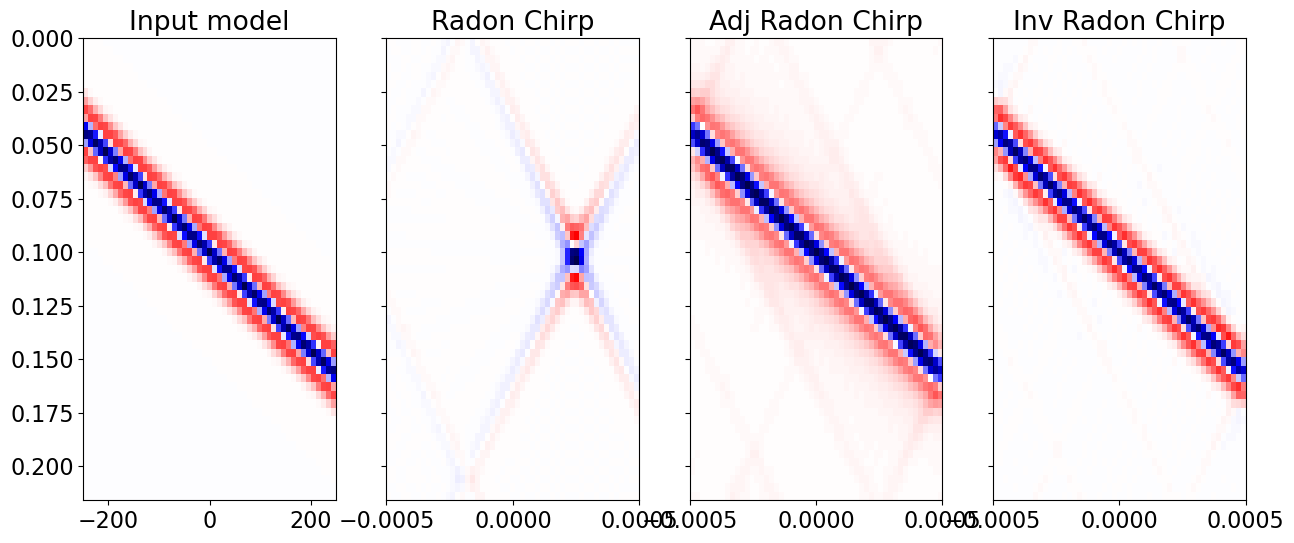

In [4]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp.T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp.T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp.T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

Test operator

In [5]:
dottest(R2Op, R2Op.shape[0], R2Op.shape[1], atol=1e-4, verb=True);

Dot test passed, v^H(Opu)=20.928626160640352 - u^H(Op^Hv)=20.928626160640214


Compare with standard Radon

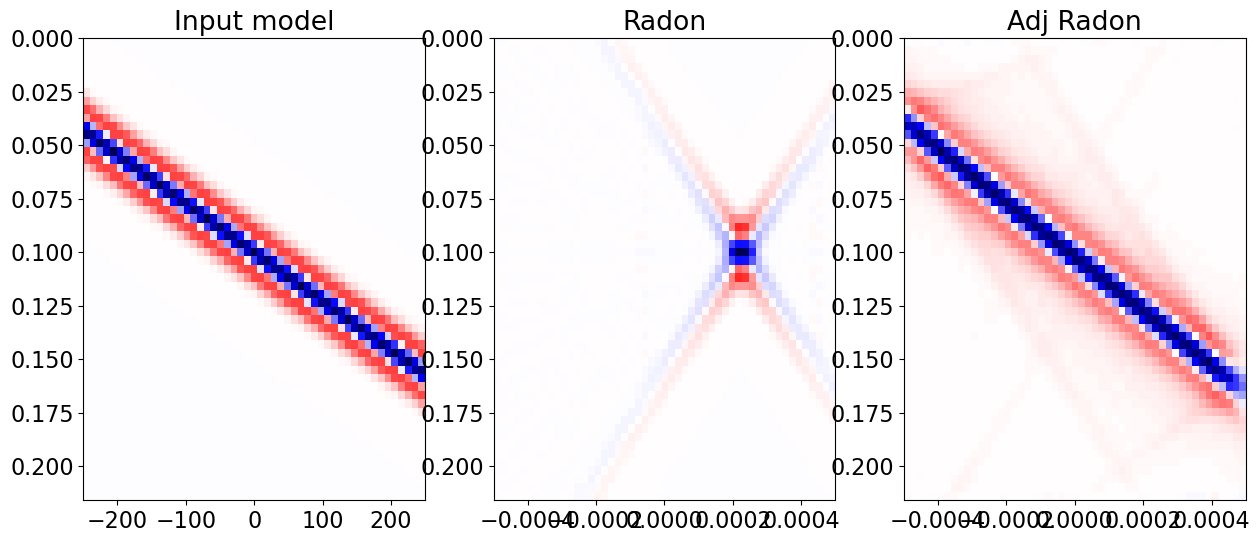

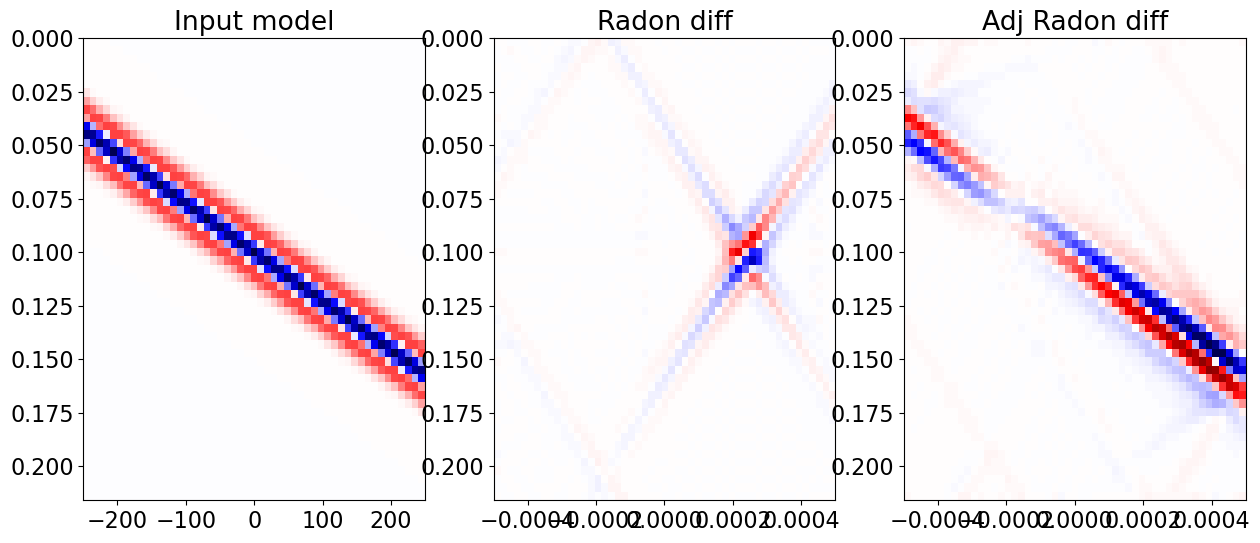

In [6]:
R2Opnormal = Radon2D(t, x, px, centeredh=True, dtype='float64', engine='numpy')
dL_normal = R2Opnormal.H * d
dadj_normal = R2Opnormal * dL_chirp

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_normal.T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(dadj_normal.T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp.T - dL_normal.T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon diff')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp.T - dadj_normal.T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon diff')
axs[2].axis('tight');

And time them

In [7]:
%timeit -n4 -r 2 R2Op * d
%timeit -n4 -r 2 R2Opnormal.T * d

452 μs ± 4.18 μs per loop (mean ± std. dev. of 2 runs, 4 loops each)
26.4 ms ± 130 μs per loop (mean ± std. dev. of 2 runs, 4 loops each)


With JAX

In [8]:
R2Opjnp = ChirpRadon2D(t, x, pxmax*dx/dt, dtype='float64')
dottest(R2Opjnp, backend='jax', verb=True, atol=1e-2)

djnp = jnp.array(d).astype(jnp.float32)

dL_chirpjnp = (R2Opjnp @ djnp).block_until_ready()
dadj_chirpjnp = (R2Opjnp.H @ dL_chirpjnp).block_until_ready()
dinv_chirpjnp = R2Opjnp.inverse(dL_chirpjnp).block_until_ready()

dL_chirpjnp = dL_chirpjnp.reshape(par['nx'], par['nt'])
dadj_chirpjnp = dadj_chirpjnp.reshape(par['nx'], par['nt'])
dinv_chirpjnp = dinv_chirpjnp.reshape(par['nx'], par['nt'])

Dot test passed, v^H(Opu)=194.40199279785156 - u^H(Op^Hv)=194.40191650390625


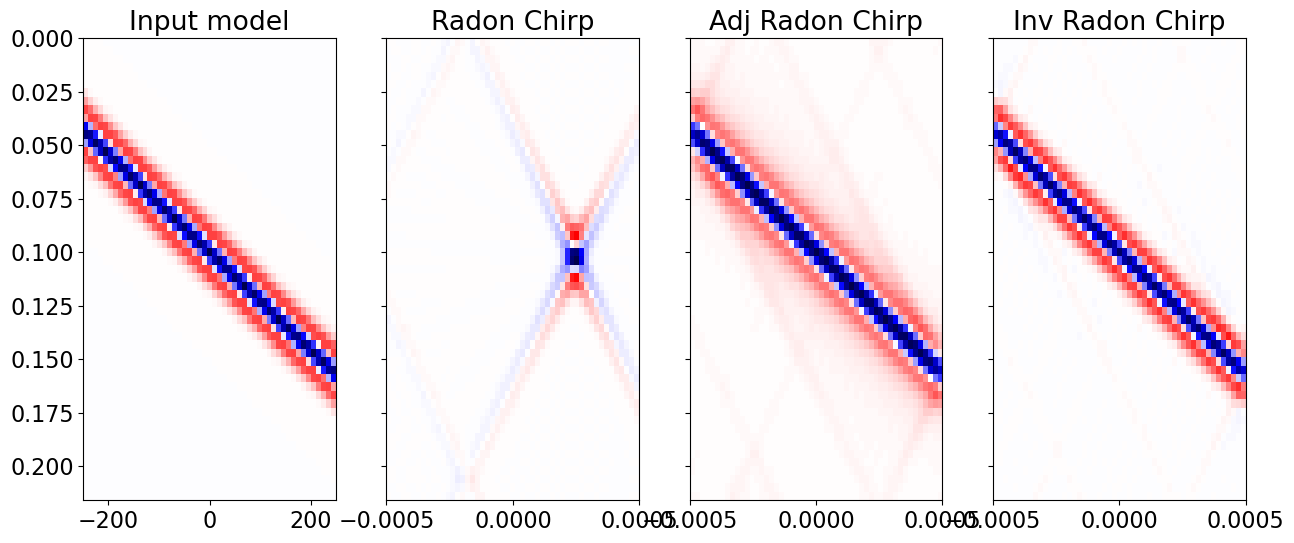

In [9]:
fig, axs = plt.subplots(1, 4, sharey=True, figsize=(15, 6))
axs[0].imshow(d.T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirpjnp.T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirpjnp.T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirpjnp.T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

In [10]:
%timeit -n4 -r 2 (R2Opjnp * djnp).block_until_ready()

1.65 ms ± 256 μs per loop (mean ± std. dev. of 2 runs, 4 loops each)


## 3D

In [11]:
#par = {'ot': 0,    'dt': 0.004, 'nt': 201,
#       'ox': -625, 'dx': 12.5, 'nx': 101,
#       'oy': -625, 'dy': 12.5, 'ny': 101,
#       'f0': 20}
#theta = [0, ]
#t0 = [0.5, ]
#amp = [1., ]

# Create axis
par = {'ot': 0,    'dt': 0.004, 'nt': 51,
       'ox': -250, 'dx': 10, 'nx': 51,
       'oy': -250, 'dy': 10, 'ny': 51,
       'f0': 40}
theta = [20, ]
t0 = [0.1, ]
amp = [1., ]

# Create axis
t, t2, x, y = pylops.utils.seismicevents.makeaxis(par)
dt, dx, dy = par['dt'], par['dx'], par['dy']

# Create wavelet
wav = pylops.utils.wavelets.ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, d = \
    pylops.utils.seismicevents.linear3d(x, y, t, 1500., t0, theta, [0, ], amp, wav)

Adjoint (from data to slantstack)

In [12]:
npy, pymax = par['ny'], 5e-4
npx, pxmax = par['nx'], 5e-4

py = np.linspace(-pymax, pymax, npy)
px = np.linspace(-pxmax, pxmax, npx)

dL_chirp = _chirp_radon_3d(d, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt))
dL_chirp1 = _chirp_radon_3d_fftw(d, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), 
                                **dict(flags=('FFTW_ESTIMATE', ), threads=2))

Forward (from slantstack to data)

In [13]:
dadj_chirp = _chirp_radon_3d(dL_chirp, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), mode='a')
dadj_chirp1 = _chirp_radon_3d_fftw(dL_chirp1, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), mode='a', 
                                  **dict(flags=('FFTW_ESTIMATE', ), threads=2))

Inverse

In [14]:
dinv_chirp = _chirp_radon_3d(dL_chirp, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), mode='i')
dinv_chirp1 = _chirp_radon_3d_fftw(dL_chirp1, dt, dx, dy, (pxmax*dx/dt, pymax*dy/dt), mode='i', 
                                  **dict(flags=('FFTW_ESTIMATE', ), threads=2))

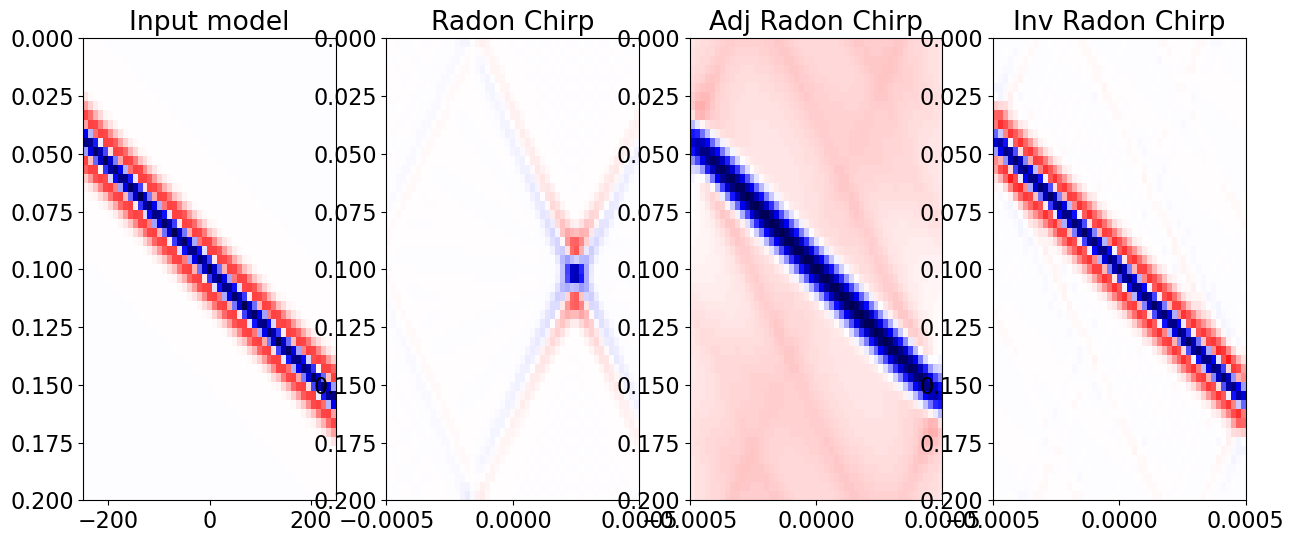

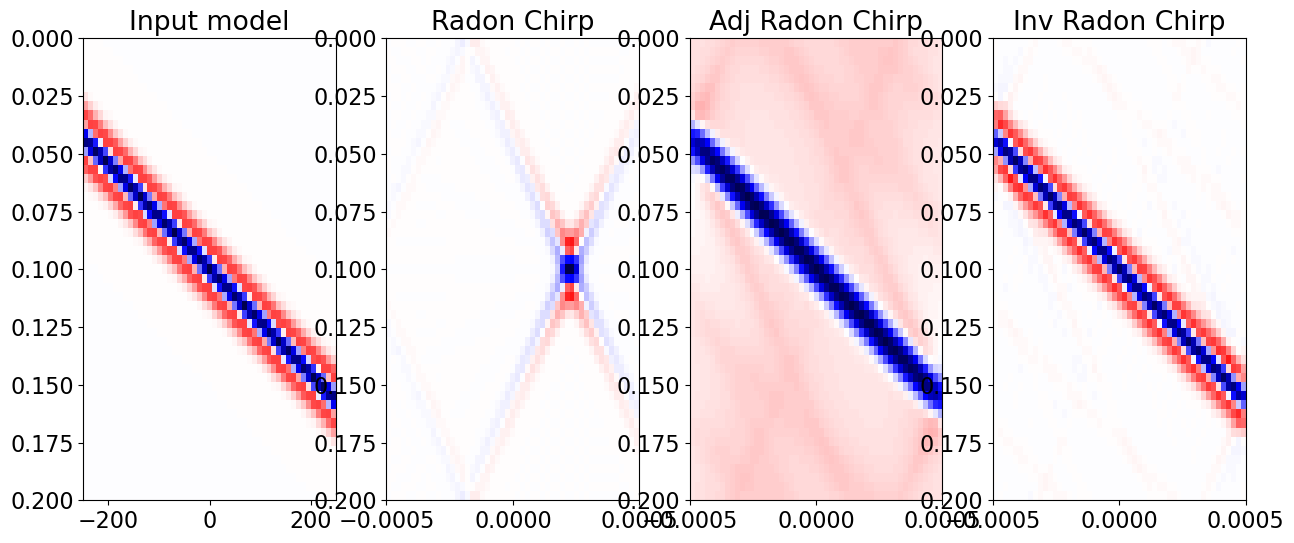

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp1[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp1[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp1[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

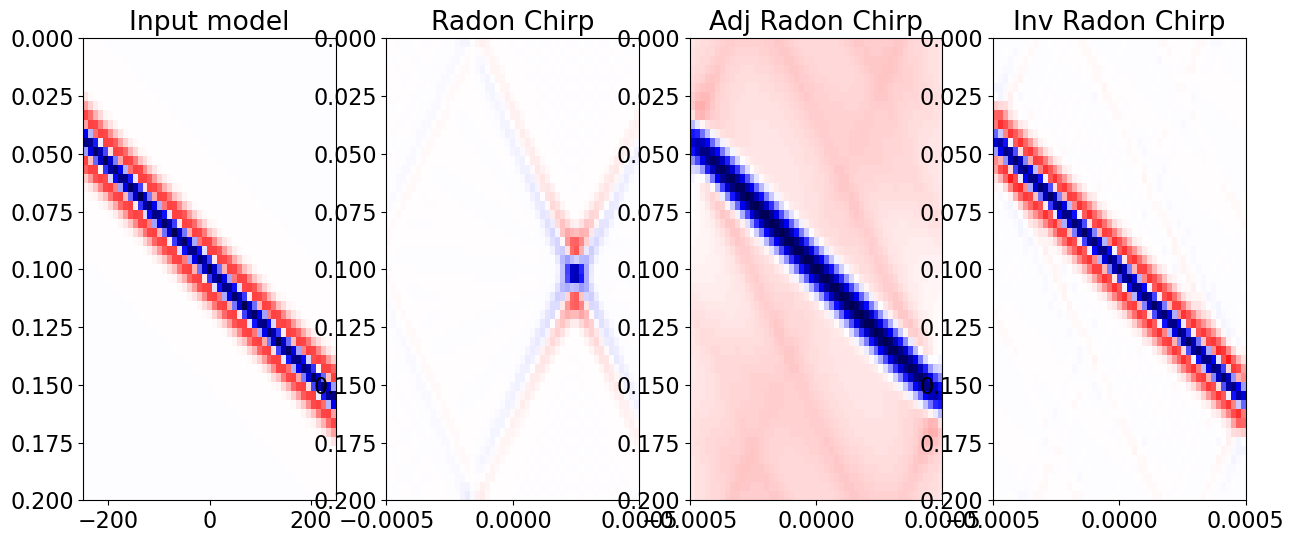

In [16]:
R3Op = ChirpRadon3D(t, y, x, (pymax*dy/dt, pxmax*dx/dt), dtype='float64')

dL_chirp = R3Op * d.ravel()
dadj_chirp = R3Op.H * dL_chirp
dinv_chirp = R3Op.inverse(dL_chirp)

dL_chirp = dL_chirp.reshape(par['ny'], par['nx'], par['nt'])
dadj_chirp = dadj_chirp.reshape(par['ny'], par['nx'], par['nt'])
dinv_chirp = dinv_chirp.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

Compare with standard Radon

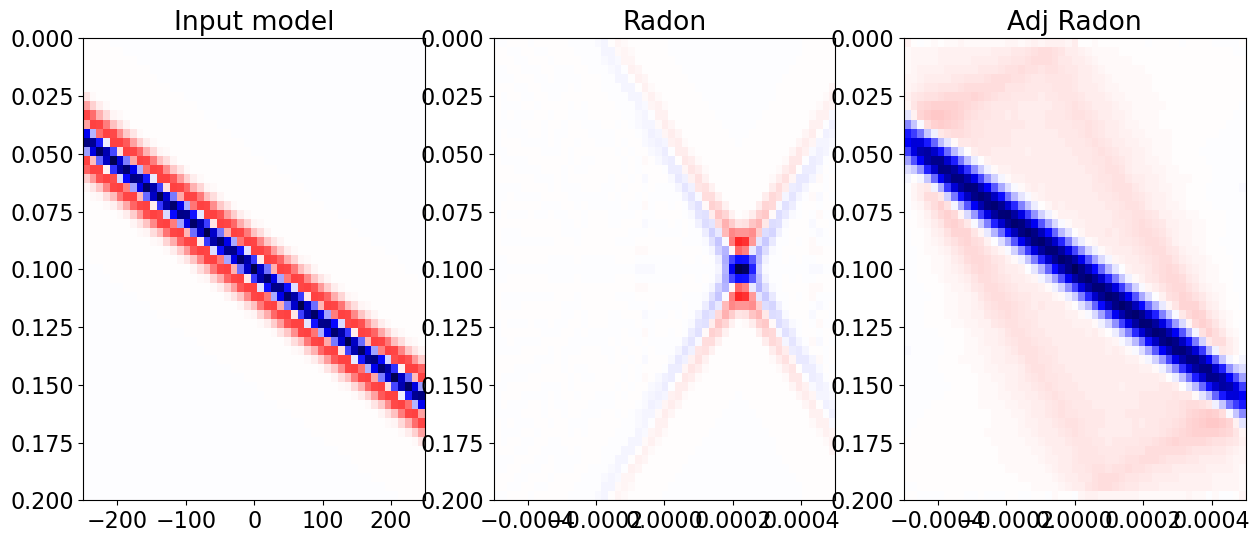

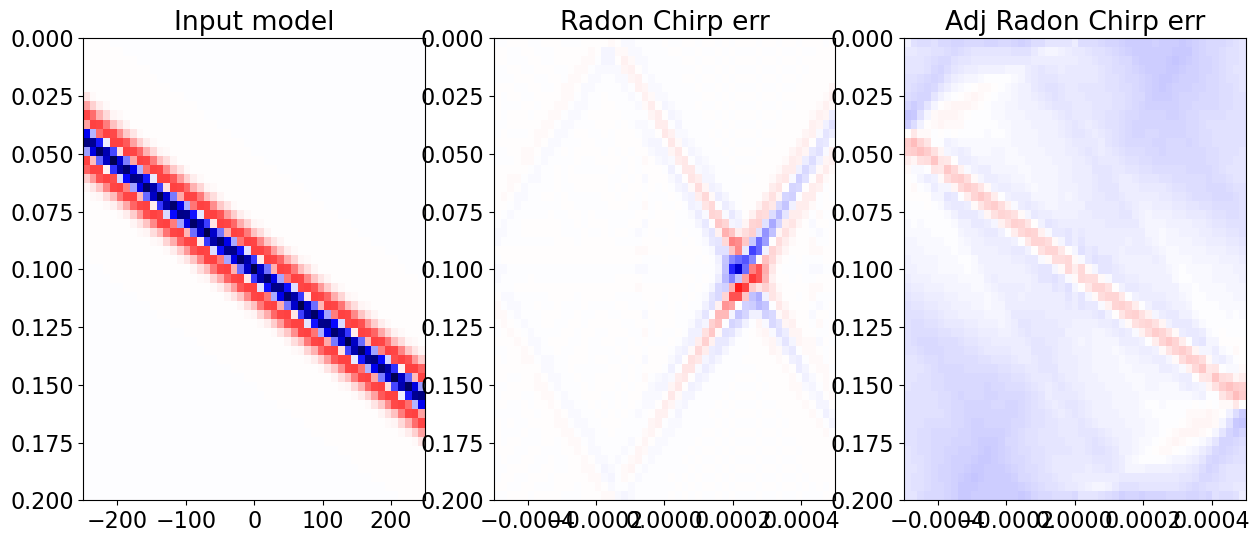

In [17]:
R3Opnormal = Radon3D(t, y, x, py, px, dtype='float64', engine='numpy')

dL_normal = R3Opnormal.H * d.ravel()
dadj_normal = R3Opnormal * dL_normal.ravel()

dL_normal = dL_normal.reshape(par['ny'], par['nx'], par['nt'])
dadj_normal = dadj_normal.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_normal[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon')
axs[1].axis('tight')
axs[2].imshow(dadj_normal[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon')
axs[2].axis('tight');

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_normal[npy//2].T - dL_chirp[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp err')
axs[1].axis('tight')
axs[2].imshow(dadj_normal[npy//2].T - dadj_chirp[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp err')
axs[2].axis('tight');

In [18]:
%timeit -n4 -r 2 R3Op * d.ravel()
%timeit -n1 -r 1 R3Opnormal.H * d.ravel()

43.3 ms ± 21.1 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)
28.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


With FFTW

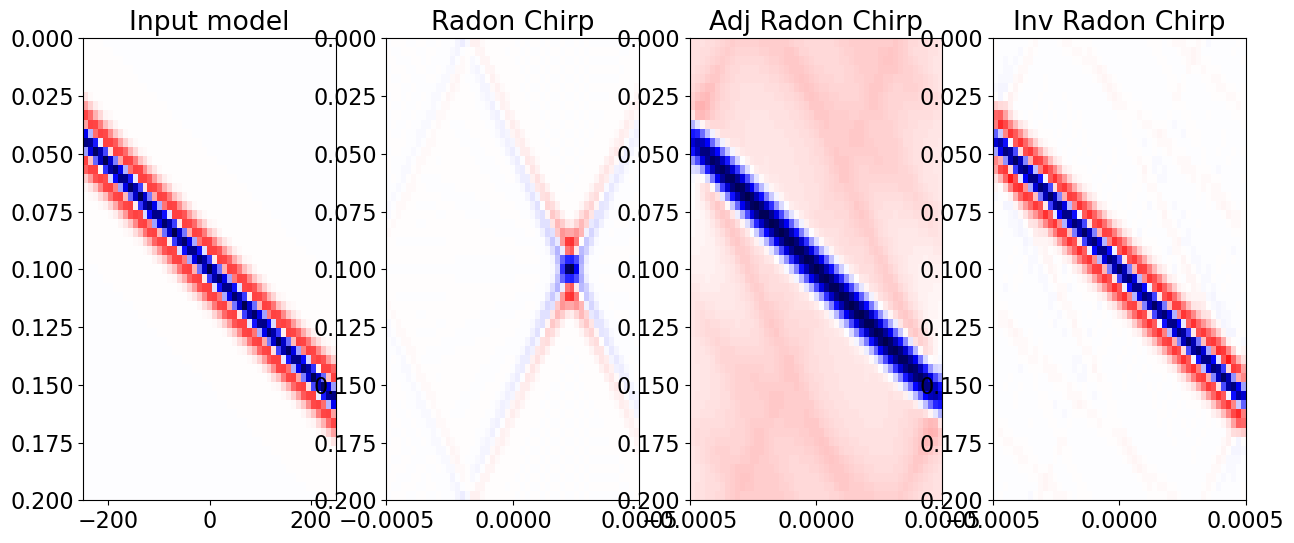

In [19]:
R3Opfftw = ChirpRadon3D(t, y, x, (pymax*dy/dt, pxmax*dx/dt), dtype='float64', engine='fftw',
                        **dict(flags=('FFTW_ESTIMATE', ), threads=2))
dL_chirp = R3Opfftw * d.ravel()
dadj_chirp = R3Opfftw.H * dL_chirp
dinv_chirp = R3Opfftw.inverse(dL_chirp)

dL_chirp = dL_chirp.reshape(par['ny'], par['nx'], par['nt'])
dadj_chirp = dadj_chirp.reshape(par['ny'], par['nx'], par['nt'])
dinv_chirp = dinv_chirp.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirp[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirp[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirp[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');

Test operator

In [20]:
dottest(R3Op, R3Op.shape[0], R3Op.shape[1], verb=True);
dottest(R3Opfftw, R3Opfftw.shape[0], R3Opfftw.shape[1], verb=True);

Dot test passed, v^H(Opu)=-4520.810545755436 - u^H(Op^Hv)=-4520.81054575553
Dot test passed, v^H(Opu)=-6920.8022439790975 - u^H(Op^Hv)=-6920.802243979084


In [21]:
%timeit -n4 -r 2 R3Op * d.ravel()
%timeit -n4 -r 2 R3Opfftw * d.ravel()

20 ms ± 731 μs per loop (mean ± std. dev. of 2 runs, 4 loops each)
14.1 ms ± 1 ms per loop (mean ± std. dev. of 2 runs, 4 loops each)


With JAX

Dot test passed, v^H(Opu)=13922.306640625 - u^H(Op^Hv)=13922.228515625


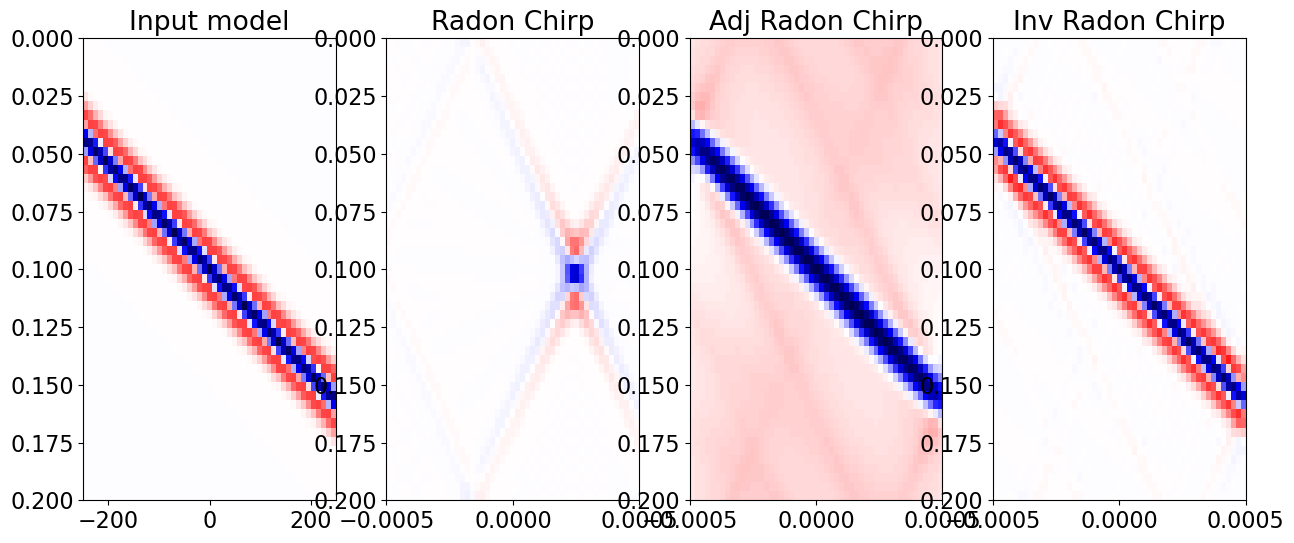

In [23]:
R3Opjnp = ChirpRadon3D(t, y, x, (pymax*dy/dt, pxmax*dx/dt), dtype='float64')

dottest(R3Opjnp, backend='jax', verb=True, atol=1e-1)

djnp = jnp.array(d).astype(jnp.float32)

dL_chirpjnp = (R3Opjnp @ djnp).block_until_ready()
dadj_chirpjnp = (R3Opjnp.H @ dL_chirpjnp).block_until_ready()
dinv_chirpjnp = R3Opjnp.inverse(dL_chirpjnp).block_until_ready()

dL_chirpjnp = dL_chirpjnp.reshape(par['ny'], par['nx'], par['nt'])
dadj_chirpjnp = dadj_chirpjnp.reshape(par['ny'], par['nx'], par['nt'])
dinv_chirpjnp = dinv_chirpjnp.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(15, 6))
axs[0].imshow(d[par['ny']//2].T, vmin=-1, vmax=1, cmap='seismic_r',
              extent=(x[0], x[-1], t[-1], t[0]))
axs[0].set_title('Input model')
axs[0].axis('tight')
axs[1].imshow(dL_chirpjnp[npy//2].T, cmap='seismic_r', vmin=-dL_chirp.max(), vmax=dL_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[1].set_title('Radon Chirp')
axs[1].axis('tight')
axs[2].imshow(dadj_chirpjnp[npy//2].T, cmap='seismic_r', vmin=-dadj_chirp.max(), vmax=dadj_chirp.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[2].set_title('Adj Radon Chirp')
axs[2].axis('tight')
axs[3].imshow(dinv_chirpjnp[npy//2].T, cmap='seismic_r', vmin=-d.max(), vmax=d.max(),
              extent=(px[0], px[-1], t[-1], t[0]))
axs[3].set_title('Inv Radon Chirp')
axs[3].axis('tight');